===== 子图切分结果 =====
Device cuda 包含节点:
  - aten::linear_16: aten::linear
  共 1 个节点

计算图切分可视化已保存为 graph_partition.png


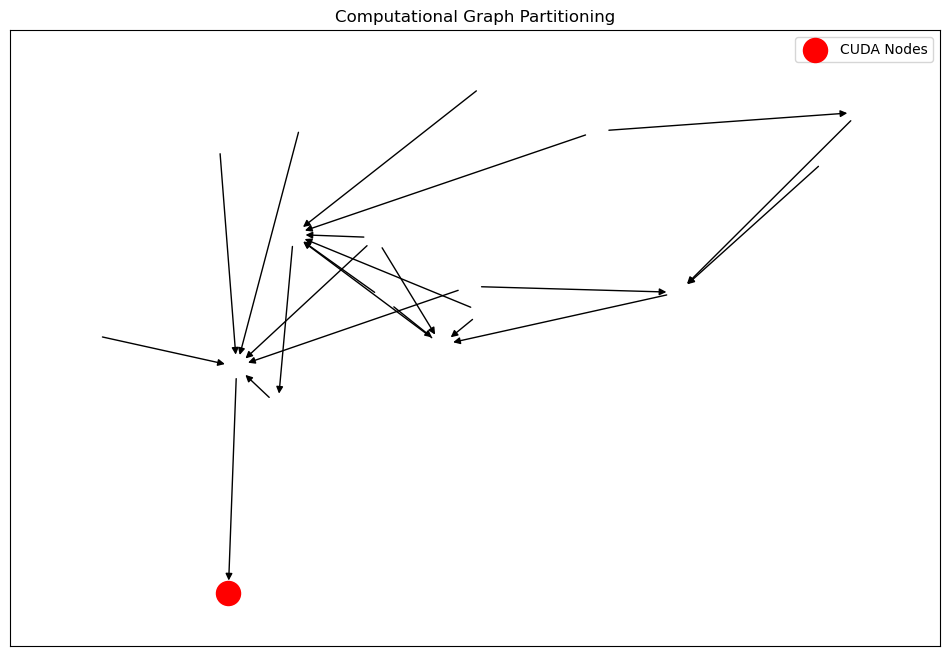

In [9]:

import torch
import torch.nn as nn
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
from torch.profiler import profile, record_function
import time
from enum import Enum, auto

# ================ 基础配置 ================
class Config:
    seq_length = 50
    input_size = 128
    hidden_size = 512
    num_layers = 2
    batch_size = 32

# ================ 模型定义 ================
class HeteroLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=Config.input_size,
            hidden_size=Config.hidden_size,
            num_layers=Config.num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(Config.hidden_size, Config.input_size)

    def forward(self, x):
        h0 = torch.zeros(Config.num_layers, x.size(0), Config.hidden_size).to(x.device)
        c0 = torch.zeros(Config.num_layers, x.size(0), Config.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out)

# ================ 动态切分器 ================
class DynamicGraphSplitter:
    def __init__(self):
        self.device_config = {
            "cpu": {"flops": 1e9, "mem_bw": 50e9},
            "cuda": {"flops": 10e12, "mem_bw": 900e9}
        }
        self.op_mapping = {
            "lstm": "cpu",
            "linear": "cuda"
        }

    def build_graph(self, model, example_input):
        """构建计算图"""
        with torch.no_grad():
            traced = torch.jit.trace(model, example_input)
            graph = traced.graph_for(example_input)
        
        G = nx.DiGraph()
        node_mapping = {}
        
        for node in graph.nodes():
            if node.kind() == 'prim::GetAttr':
                continue
                
            node_name = f"{node.kind()}_{len(node_mapping)}"
            node_mapping[node] = node_name
            
            device = 'cuda'  # 默认设备
            for op_type, dev in self.op_mapping.items():
                if op_type in node.kind().lower():
                    device = dev
                    break
            
            G.add_node(node_name, 
                      op_type=node.kind(),
                      device=device,
                      output_size=self._estimate_output_size(node))
        
        # 添加边
        for node in graph.nodes():
            if node not in node_mapping:
                continue
            for inp in node.inputs():
                if inp.node() in node_mapping:
                    G.add_edge(node_mapping[inp.node()], node_mapping[node])
        
        return G

    def _estimate_output_size(self, node):
        """估算节点输出大小（简化版）"""
        if 'lstm' in node.kind().lower():
            return Config.batch_size * Config.seq_length * Config.hidden_size
        elif 'linear' in node.kind().lower():
            return Config.batch_size * Config.seq_length * Config.input_size
        return 1  # 默认值

    def split_graph(self, G):
        """改进的动态规划切分算法"""
        devices = list(set(nx.get_node_attributes(G, 'device').values()))
        dp_table = {n: {d: float('inf') for d in devices} for n in G.nodes}
        path = {}
        
        # 处理无前驱的节点（起始节点）
        for node in G.nodes():
            if not list(G.predecessors(node)):  # 没有前驱节点
                for d in devices:
                    dp_table[node][d] = self._compute_node_cost(node, G, d)
        
        # 拓扑排序处理
        for node in nx.topological_sort(G):
            preds = list(G.predecessors(node))
            if not preds:  # 起始节点已处理过
                continue
                
            for curr_dev in devices:
                # 计算当前节点在当前设备上的成本
                compute_cost = self._compute_node_cost(node, G, curr_dev)
                
                # 找出使总成本最小的前驱设备组合
                min_pred_cost = 0
                best_pred_devs = {}
                for pred in preds:
                    best_dev = min(devices, key=lambda d: dp_table[pred][d])
                    min_pred_cost += dp_table[pred][best_dev]
                    best_pred_devs[pred] = best_dev
                
                total_cost = compute_cost + min_pred_cost
                if total_cost < dp_table[node][curr_dev]:
                    dp_table[node][curr_dev] = total_cost
                    path[node] = {curr_dev: best_pred_devs}
        
        # 回溯最优路径
        best_partitions = defaultdict(list)
        last_node = list(nx.topological_sort(G))[-1]
        curr_dev = min(dp_table[last_node].items(), key=lambda x: x[1])[0]
        
        # 从后向前回溯
        stack = [(last_node, curr_dev)]
        while stack:
            node, dev = stack.pop()
            best_partitions[dev].append(node)
            if node in path and dev in path[node]:
                for pred, pred_dev in path[node][dev].items():
                    stack.append((pred, pred_dev))
            
        return best_partitions

    def _compute_node_cost(self, node, G, target_dev):
        """计算节点在目标设备上的执行成本（带容错处理）"""
        try:
            op_type = G.nodes[node]['op_type']
            input_size = sum(G.nodes[p]['output_size'] for p in G.predecessors(node))
            
            # 计算时间
            compute_time = (input_size * 2) / self.device_config[target_dev]["flops"]
            
            # 通信时间
            comm_time = 0
            for p in G.predecessors(node):
                if G.nodes[p]['device'] != target_dev:
                    comm_time += input_size / self.device_config[target_dev]["mem_bw"]
                    
            return compute_time + comm_time * 0.5  # 通信惩罚系数
        except Exception as e:
            print(f"Error calculating cost for {node}: {str(e)}")
            return float('inf')

# ================ 主执行流程 ================
if __name__ == "__main__":
    # 初始化模型
    model = HeteroLSTM().eval()
    input_data = torch.randn(Config.batch_size, Config.seq_length, Config.input_size)
    
    # 动态切分
    splitter = DynamicGraphSplitter()
    G = splitter.build_graph(model, input_data)
    partitions = splitter.split_graph(G)
    
    # 打印切分结果
    print("===== 子图切分结果 =====")
    for device, nodes in partitions.items():
        print(f"Device {device} 包含节点:")
        for node in nodes[:3]:  # 只打印前3个节点示例
            print(f"  - {node}: {G.nodes[node]['op_type']}")
        print(f"  共 {len(nodes)} 个节点\n")
    
    # 可视化
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    colors = {'cpu': 'blue', 'cuda': 'red'}
    for device, nodes in partitions.items():
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, 
                              node_color=colors[device],
                              label=f'{device.upper()} Nodes')
    nx.draw_networkx_edges(G, pos)
    plt.legend()
    plt.title("Computational Graph Partitioning")
    plt.savefig("graph_partition.png")
    print("计算图切分可视化已保存为 graph_partition.png")



DiGraph with 17 nodes and 22 edges
===== 子图切分结果 =====
Device npu 包含节点:
  - aten::linear_16: aten::linear
  - aten::lstm_15: aten::lstm
  - prim::Constant_3: prim::Constant
  - prim::Constant_1: prim::Constant
  - prim::Constant_7: prim::Constant
  - prim::Constant_0: prim::Constant
  - prim::ListConstruct_14: prim::ListConstruct
  - prim::ListConstruct_13: prim::ListConstruct
  - aten::to_12: aten::to
  - prim::Constant_5: prim::Constant
  - prim::Constant_4: prim::Constant
  - prim::Constant_8: prim::Constant
  - prim::Constant_2: prim::Constant
  - aten::zeros_11: aten::zeros
  - prim::ListConstruct_10: prim::ListConstruct
  - prim::Constant_6: prim::Constant
  - aten::size_9: aten::size
  共 17 个节点

计算图切分可视化已保存为 graph_partition.png


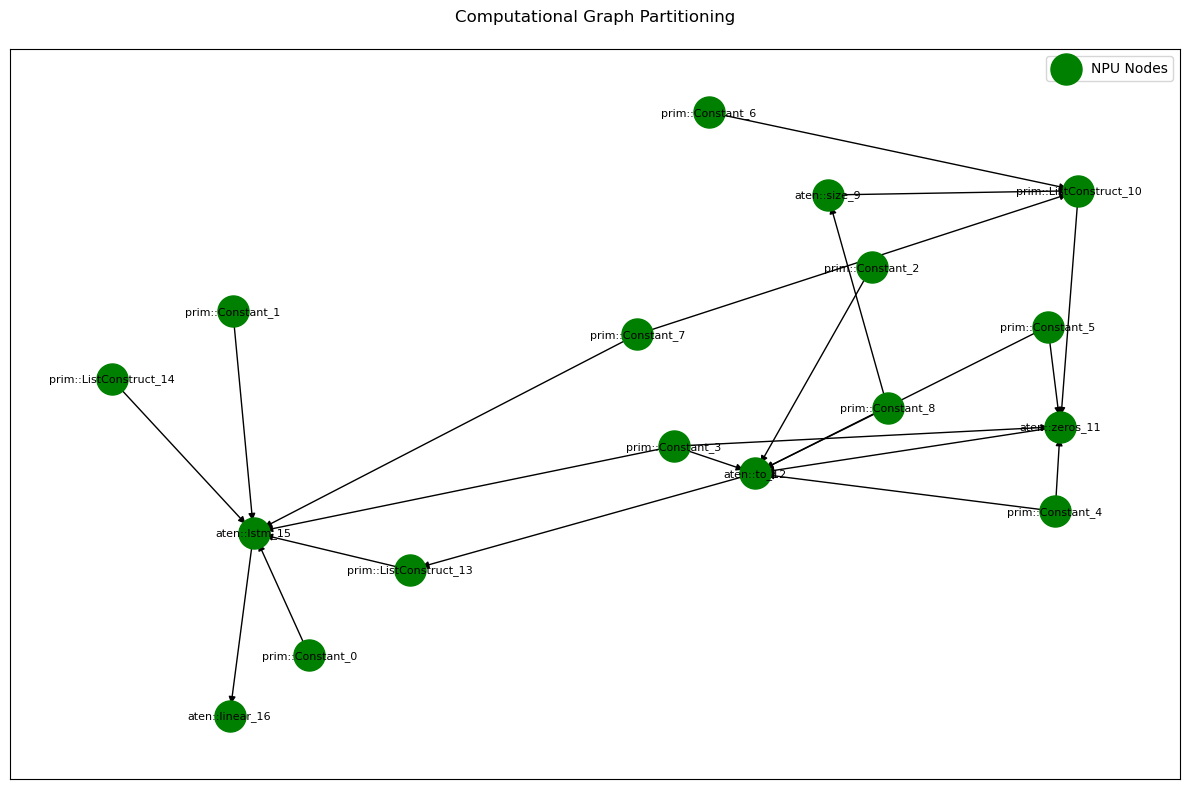

In [3]:
import torch
import torch.nn as nn
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
from torch.profiler import profile, record_function
import time
from enum import Enum, auto

# ================ 基础配置 ================
class Config:
    """模型参数配置类"""
    seq_length = 50      # 输入序列长度
    input_size = 128     # 输入特征维度
    hidden_size = 512    # LSTM隐藏层大小
    num_layers = 2       # LSTM层数
    batch_size = 32      # 批处理大小

# ================ 模型定义 ================
class HeteroLSTM(nn.Module):
    """异构LSTM模型（CPU+GPU混合）"""
    def __init__(self):
        super().__init__()
        # LSTM层默认在CPU（适合序列处理）
        self.lstm = nn.LSTM(
            input_size=Config.input_size,
            hidden_size=Config.hidden_size,
            num_layers=Config.num_layers,
            batch_first=True
        )
        # 全连接层默认在GPU（适合并行计算）
        self.fc = nn.Linear(Config.hidden_size, Config.input_size)

    def forward(self, x):
        """前向传播（需确保输入张量已在正确设备）"""
        # 初始化隐藏状态（自动匹配输入设备）
        h0 = torch.zeros(Config.num_layers, x.size(0), Config.hidden_size).to(x.device)
        c0 = torch.zeros(Config.num_layers, x.size(0), Config.hidden_size).to(x.device)
        
        # LSTM处理
        out, _ = self.lstm(x, (h0, c0))
        
        # 全连接层处理
        return self.fc(out)

# ================ 动态切分器 ================
class DynamicGraphSplitter:
    """基于动态规划的计算图切分器"""
    def __init__(self):
        # 设备硬件规格（需根据实际设备校准）

        #在测试中，按照当前配置：cpu-1e9的算力，gpu-10e12的算力，最后分配下来全部计算节点都在gpu
        self.device_config = {
            "cpu": {
                "flops": 1e9,    # CPU理论计算能力（1G FLOPS）
                "mem_bw": 50e9    # CPU内存带宽（50GB/s）
            },
            "cuda": {
                "flops": 10e12,   # GPU理论计算能力（10T FLOPS）
                "mem_bw": 900e9   # GPU显存带宽（900GB/s）
            },
            "npu":{
                "flops":11e12,   
                "mem_bw": 1e12
            }
        }
        
        # 算子到设备的默认映射规则
        self.op_mapping = {
            "lstm": "cpu",   # LSTM更适合CPU顺序处理
            "linear": "cuda"  # 矩阵乘更适合GPU并行
        }
        
        # 通信成本系数（关键参数！需要实测校准）
        # self.comm_cost = 2  # 修正建议：应改为1.5-2.0（时间惩罚系数）

    def build_graph(self, model, example_input):
        """构建计算图DAG"""
        with torch.no_grad():
            # 使用JIT追踪模型
            
            traced = torch.jit.trace(model, example_input)
            graph = traced.graph_for(example_input)  # 获取计算图
            ##上面操作完毕之后比如：
            # class SimpleModel(nn.Module):
                # def forward(self, x):
                    # x = x * 2          # 操作1：乘法
                    # x = x + 1          # 操作2：加法
                    # return x
            #这样的模型，最终会得到如下的语句：
            # %x.1 : Float(3, strides=[1], requires_grad=0, device=cpu)):
            # %4 : Long(...) = prim::Constant[value={2}]()  # 常量2
            # %x : Float(3,...) = aten::mul(%x.1, %4)       # 乘法操作
            # %6 : Long(...) = prim::Constant[value={1}]()  # 常量1
            # %7 : int = prim::Constant[value=1]()          # 标量1（用于add的alpha参数）
            # %8 : Float(3,...) = aten::add(%x, %6, %7)     # 加法操作
            # return (%8)                                   # 返回结果
            #这些类似汇编的语句描述了整个过程！！！
            
        
        G = nx.DiGraph()  # 创建有向无环图
        node_mapping = {} # 节点名称映射表
        
        # 第一遍：添加所有计算节点
        for node in graph.nodes():
            if node.kind() == 'prim::GetAttr':  # 跳过属性节点
                continue
                
            # 生成唯一节点名
            node_name = f"{node.kind()}_{len(node_mapping)}"
            node_mapping[node] = node_name
            
            # 根据算子类型分配默认设备（这只是一开始的初始化，不是最终的分配结果）

            device = 'cuda'  # 最开始我们默认GPU
            for op_type, dev in self.op_mapping.items():
                #如果算子类型在我们的预设之中，我们就初始化的时候就分配到对应的；如果不在，就在这里的初始化中分配到cuda
                if op_type in node.kind().lower():
                    device = dev
                    break
            
            # 添加节点属性
            G.add_node(node_name, 
                      op_type=node.kind(),
                      device=device,
                      output_size=self._estimate_output_size(node))
        
        # 第二遍：添加数据依赖边
        for node in graph.nodes():
            # 跳过未注册的节点（如 prim::GetAttr）
            if node not in node_mapping:
                continue

            # 遍历当前节点的所有输入
            for inp in node.inputs():
                # 检查输入是否来自已注册的节点
                if inp.node() in node_mapping:
                    # 添加边：从输入节点 -> 当前节点
                    G.add_edge(node_mapping[inp.node()], node_mapping[node])
        
        return G

    def _estimate_output_size(self, node):#这个函数可以再进行优化
        """估算节点输出张量大小（字节数），这里是为了后面计算通信成本的"""
        if 'lstm' in node.kind().lower():
            return Config.batch_size * Config.seq_length * Config.hidden_size * 4  # float32=4bytes
        elif 'linear' in node.kind().lower():
            return Config.batch_size * Config.seq_length * Config.input_size * 4
        return 1  # 默认值（应避免）


    def split_graph(self, G):
        # devices = list(set(nx.get_node_attributes(G, 'device').values()))
        devices = list(self.device_config.keys())  # ✅ 强制包含所有设备
        dp_table = {n: {d: float('inf') for d in devices} for n in G.nodes()}
        path = {}

        # 初始化无前驱节点
        for node in G.nodes():
            if not list(G.predecessors(node)):
                for d in devices:
                    dp_table[node][d] = self._compute_node_cost(node,d)

        # 动态规划填充表格
        for node in nx.topological_sort(G):
            preds = list(G.predecessors(node))
            if not preds:
                continue

            # 修改 split_graph 方法中的对应部分
            for curr_dev in devices:
                compute_cost = self._compute_node_cost(node, curr_dev)
                max_pred_cost = 0  # 用于记录前驱中的最大成本
                
                best_pred_devs = {}
                
                for pred in preds:
                    min_pred_cost = float('inf')
                    best_dev = None
                    
                    for pred_dev in devices:
                        pred_cost = dp_table[pred][pred_dev]
                        comm_cost = self._compute_comm_cost(pred, pred_dev, curr_dev) if pred_dev != curr_dev else 0
                        total = pred_cost + comm_cost
                        
                        if total < min_pred_cost:
                            min_pred_cost = total
                            best_dev = pred_dev
                            
                    best_pred_devs[pred] = best_dev
                    max_pred_cost = max(max_pred_cost, min_pred_cost)  # ✅ 取最大值
                
                total_cost = compute_cost + max_pred_cost  # 总成本 = 当前计算 + 最大前驱成本
                
                if total_cost < dp_table[node][curr_dev]:
                    dp_table[node][curr_dev] = total_cost
                    path[node] = {curr_dev: best_pred_devs}


        # 新增：完整的路径回溯
        best_partitions = defaultdict(list)
        if not G.nodes():
            return dict(best_partitions), []

        last_node = list(nx.topological_sort(G))[-1]
        curr_dev = min(dp_table[last_node].items(), key=lambda x: x[1])[0]

        stack = [(last_node, curr_dev)]
        visited = set()
        
        while stack:
            node, dev = stack.pop()
            if (node, dev) in visited:
                continue
            visited.add((node, dev))
            best_partitions[dev].append(node)

            if node in path and dev in path[node]:
                for pred, pred_dev in path[node][dev].items():
                    stack.append((pred, pred_dev))

        return best_partitions

    def _compute_node_cost(self, node, device):
        """计算节点在目标设备上的纯计算时间"""
        # 假设节点有input_size属性（根据输入数据量估算）
        input_size = getattr(node, 'input_size', 1e6)  # 默认1MB
        flops = self.device_config[device]["flops"]    # 设备算力（FLOP/s）
        return input_size * 2 / flops  # 乘2近似计算量（FLOP/byte）


    
    def _compute_comm_cost(self, src_node, src_dev, dst_dev):
        """改进的通信成本计算"""
        data_size = G.nodes[src_node]['output_size']
        
        # 使用两端设备的最小带宽
        bw = min(
            self.device_config[src_dev]["mem_bw"],
            self.device_config[dst_dev]["mem_bw"]
        )
        
        # 增加内存复制固定开销（实测建议值）
        fixed_overhead = 10e-6  # 10 microseconds
        return fixed_overhead + data_size / bw

# ================ 主执行流程 ================
if __name__ == "__main__":
    # 模型初始化
    model = HeteroLSTM().eval()
    input_data = torch.randn(Config.batch_size, Config.seq_length, Config.input_size)
    
    # 计算图切分
    splitter = DynamicGraphSplitter()
    G = splitter.build_graph(model, input_data)
    print(G)
    partitions = splitter.split_graph(G)
    
    # 结果输出
    print("===== 子图切分结果 =====")
    for device, nodes in partitions.items():
        print(f"Device {device} 包含节点:")
        for node in nodes:  
            print(f"  - {node}: {G.nodes[node]['op_type']}")
        print(f"  共 {len(nodes)} 个节点\n")
        

    # 可视化
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.5)  # k控制节点间距

    # ✅ 添加对 NPU 的颜色支持
    colors = {
        'cpu': 'blue',
        'cuda': 'red',
        'npu': 'green'
    }

    for device, nodes in partitions.items():
        nx.draw_networkx_nodes(
            G, pos, nodelist=nodes,
            node_color=colors[device],
            node_size=500,
            label=f'{device.upper()} Nodes'
        )

    nx.draw_networkx_edges(G, pos, arrows=True)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.legend(scatterpoints=1)
    plt.title("Computational Graph Partitioning", pad=20)
    plt.tight_layout()
    plt.savefig("graph_partition.png", dpi=300)
    print("计算图切分可视化已保存为 graph_partition.png")